In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
import geopandas as gpd
from geopandas.datasets import get_path
import geopandas.tools as gpd_tools
from shapely.geometry import Point
from math import radians, sqrt
from geopy.distance import great_circle
from sklearn.metrics.pairwise import haversine_distances
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse

In [2]:
# Path to the zip file
zip_path = 'airbnb_data.zip'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as z:
    # Filter out non-CSV or macOS metadata files
    csv_files = [file for file in z.namelist() if file.endswith('.csv') and '__MACOSX' not in file]

    # List to store the DataFrames
    dataframes = []
    for csv_file in csv_files:
        with z.open(csv_file) as f:
            df = pd.read_csv(f, encoding='utf-8', dtype={'license': 'object'})
            dataframes.append(df)

In [3]:
df_original = pd.concat(dataframes)

In [4]:
df_original.shape

(1031314, 79)

**The dataset has 1031314 observations and 75 features.**

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031314 entries, 0 to 39318
Data columns (total 79 columns):
 #   Column                                        Non-Null Count    Dtype  
---  ------                                        --------------    -----  
 0   id                                            1031314 non-null  int64  
 1   listing_url                                   1031314 non-null  object 
 2   scrape_id                                     1031314 non-null  int64  
 3   last_scraped                                  1031314 non-null  object 
 4   source                                        1031314 non-null  object 
 5   name                                          1031243 non-null  object 
 6   description                                   930174 non-null   object 
 7   neighborhood_overview                         585888 non-null   object 
 8   picture_url                                   1031303 non-null  object 
 9   host_id                              

**In the cell below, the formatting of the `price` feature is converted to numeric value by removing the '$' and asssinging it as a float. Null values for `price` and $0 listings were removed from the dataset.**

In [6]:
df_original['price'] = df_original['price'].replace('[\$,]', '', regex=True).astype(float)
df_original = df_original.dropna(subset=['price'])
df_original = df_original[df_original['price'] !=0]

In [7]:
df_original['id'].nunique()

70989

**There are 70989 unique Airbnb listings in New York City**

In [8]:
df_original.duplicated(subset=['id']).sum()

743671

In [9]:
df = df_original.drop_duplicates(subset=['id'], keep='last')

**Based on the subset of assuming that previous listings appear in later scrapes, 699575 duplicates were found. These observations will be dropped from the DataFrame.**

In [10]:
df.shape

(70989, 79)

**After dropping the duplicates, there are 70989 observations remaining.**

**The features stored in `drop_col` below are either represented more thoroughly in another feature (repetitive) or are redundant and don't provide insight in the price prediction models. After dropping those columns, there are 20 features remaining**

In [11]:
drop_col = ['listing_url', 'scrape_id', 'source', 'name', 'description', 'neighborhood_overview',
            'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
            'host_response_time', 'host_response_rate', 'host_thumbnail_url', 'host_picture_url', 
            'host_neighbourhood', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 
            'host_identity_verified', 'neighbourhood', 'bathrooms', 'minimum_minimum_nights', 'maximum_minimum_nights',
            'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
            'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
            'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
            'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
            'review_scores_value','license', 'calculated_host_listings_count', 
            'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'availability_eoy',
            'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d']

In [12]:
df = df.drop(columns=drop_col)
df.shape

(70989, 21)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70989 entries, 1839 to 39202
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            70989 non-null  int64  
 1   last_scraped                  70989 non-null  object 
 2   host_acceptance_rate          54214 non-null  object 
 3   host_is_superhost             69741 non-null  object 
 4   host_total_listings_count     70981 non-null  float64
 5   neighbourhood_cleansed        70989 non-null  object 
 6   neighbourhood_group_cleansed  70989 non-null  object 
 7   latitude                      70989 non-null  float64
 8   longitude                     70989 non-null  float64
 9   property_type                 70989 non-null  object 
 10  room_type                     70989 non-null  object 
 11  accommodates                  70989 non-null  int64  
 12  bathrooms_text                70919 non-null  object 
 13

**In the cell below, the `host_acceptance_rate` feature is converted into a float by removing the special character % and assigning it a float.**

**I also rename the neighborhood columns to clearer feature names.**

In [14]:
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('%', '', regex=True).astype(float)
df = df.rename(columns={'neighbourhood_cleansed':'neighborhood', 'neighbourhood_group_cleansed':'borough'})

In [15]:
df = df.sort_values(by=['id', 'last_scraped'], ignore_index=True)

In [16]:
df.head()

,id,last_scraped,host_acceptance_rate,host_is_superhost,host_total_listings_count,neighborhood,borough,latitude,longitude,property_type,...,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,review_scores_rating,instant_bookable
0,2595,2024-03-08,25.0,f,9.0,Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,...,1,1 bath,0.0,1.0,"[""Oven"", ""Ethernet connection"", ""Dishes and si...",240.0,30,1125,4.68,f
1,5121,2024-03-08,NaN,f,2.0,Bedford-Stuyvesant,Brooklyn,40.68535,-73.95512,Private room in rental unit,...,2,1 bath,1.0,1.0,"[""Air conditioning"", ""Kitchen"", ""Wifi"", ""Heati...",72.0,30,150,4.52,f
2,5136,2023-03-06,50.0,f,5.0,Sunset Park,Brooklyn,40.66265,-73.99454,Entire rental unit,...,4,1.5 baths,2.0,2.0,"[""Air conditioning"", ""Refrigerator"", ""Outdoor ...",275.0,60,1125,5.00,f
3,5178,2023-03-07,100.0,f,1.0,Midtown,Manhattan,40.76457,-73.98317,Private room in rental unit,...,2,1 bath,1.0,1.0,"[""Hangers"", ""Microwave"", ""Hot water"", ""TV"", ""L...",68.0,2,14,4.25,f
4,5203,2023-03-06,NaN,f,5.0,Upper West Side,Manhattan,40.80380,-73.96751,Private room in rental unit,...,1,1 shared bath,1.0,1.0,"[""Air conditioning"", ""Fire extinguisher"", ""Bre...",75.0,2,14,4.91,f


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70989 entries, 0 to 70988
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         70989 non-null  int64  
 1   last_scraped               70989 non-null  object 
 2   host_acceptance_rate       54214 non-null  float64
 3   host_is_superhost          69741 non-null  object 
 4   host_total_listings_count  70981 non-null  float64
 5   neighborhood               70989 non-null  object 
 6   borough                    70989 non-null  object 
 7   latitude                   70989 non-null  float64
 8   longitude                  70989 non-null  float64
 9   property_type              70989 non-null  object 
 10  room_type                  70989 non-null  object 
 11  accommodates               70989 non-null  int64  
 12  bathrooms_text             70919 non-null  object 
 13  bedrooms                   60229 non-null  flo

## Handling Missing Values

In [18]:
df.isnull().sum()

id                               0
last_scraped                     0
host_acceptance_rate         16775
host_is_superhost             1248
host_total_listings_count        8
neighborhood                     0
borough                          0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms_text                  70
bedrooms                     10760
beds                          1062
amenities                        0
price                            0
minimum_nights                   0
maximum_nights                   0
review_scores_rating         26459
instant_bookable                 0
dtype: int64

**All numeric features containing null values are replaced with the median value of each respective feature. All categorical features containing null values are replaced with the mode value for each respective feature. This is to help retain as much data as possible.**

In [19]:
missing_numeric_cols = []

for col in df.columns:
    if df[col].isnull().sum() > 0 and df[col].dtype != 'object':
        missing_numeric_cols.append(col)

for col in missing_numeric_cols:
     df.loc[:, col] = df[col].fillna(df[col].median())

In [20]:
missing_categorical_cols = []

for col in df.columns:
    if (df[col].isnull().sum() > 0 and df[col].dtype == 'object'):
         missing_categorical_cols.append(col)

for col in missing_categorical_cols:
     df.loc[:, col] = df[col].fillna(df[col].mode()[0])

In [21]:
df.isnull().sum()

id                           0
last_scraped                 0
host_acceptance_rate         0
host_is_superhost            0
host_total_listings_count    0
neighborhood                 0
borough                      0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms_text               0
bedrooms                     0
beds                         0
amenities                    0
price                        0
minimum_nights               0
maximum_nights               0
review_scores_rating         0
instant_bookable             0
dtype: int64

**Unlike other features, the `amenities` feature is a list of amenities. A null value appears as [] (an empty list). Therefore, observations where the `amenities` column contains an empty list will be removed from the dataset.**

In [22]:
len(df[df['amenities'] == '[]'])

856

In [23]:
df = df[df['amenities'] != '[]']

## Handling Outliers

**A function `detect_outliers` uses the interquartile range method to detect observations that are out of the range +/- 1.5 * Q1 and Q3. The outliers are visualized to see which the degree of skewed data for each feature.**

The bar charts after the `detect_outliers` function visualize the number of outliers of the features that were detected to contain outliers.

The outliers for the `price` feature are removed to avoid manipulating the target feature, and the remaining features are replaced with the median from their respective column. The `latitude` and `longitude` features are left unchanged.

In [24]:
def detect_outliers(df, cols):
    # Create a new DataFrame to store total outlier counts
    df_outliers_count = pd.DataFrame(index=['total_outliers'])

    for col in df.columns:
        if df[col].dtype=='float64' or df[col].dtype=='int64':
            # Calculate quartiles and IQR for the column
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1

            # Identify outliers using the IQR method
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outliers = ((df[col] < lower) | (df[col] > upper))

            # Count the total number of outliers for each column
            total_outliers = outliers.sum()

            # Store total outlier counts in the new DataFrame
            df_outliers_count[col] = total_outliers

    return df_outliers_count

In [25]:
outliers_df = detect_outliers(df, df.columns)
outliers_df

,id,host_acceptance_rate,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating
total_outliers,0,8274,12925,849,5173,2979,2552,4653,5227,1209,12,9351


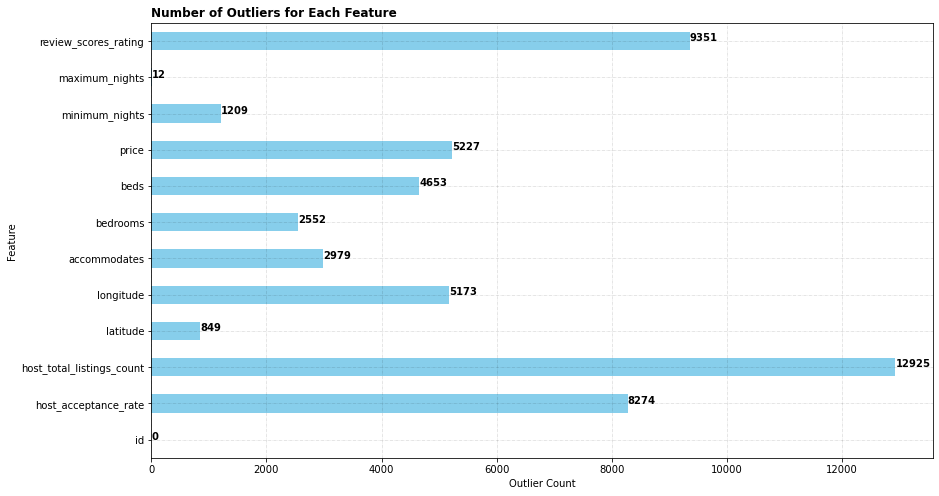

In [26]:
outliers_count = outliers_df.iloc[0]

fig, ax = plt.subplots(figsize=(14, 8))

# Plot outliers
outliers_count.plot(kind='barh', color='skyblue')

# Add gridlines
ax.grid(color='black', linestyle='-.', linewidth=0.5, alpha=0.2)

# Add annotation to bars
for i, v in enumerate(outliers_count):
    plt.text(v + 0.2, i, str(round(v, 2)), fontdict={'fontsize':10, 'fontweight':'bold'})

ax.set_title('Number of Outliers for Each Feature', loc='left', fontweight='bold')

plt.xlabel('Outlier Count')
plt.ylabel('Feature')
plt.show()

In [27]:
def remove_outliers(df, cols):

    # Create a copy of the DataFrame to avoid modifying the original
    df_outliers = df.copy()

    # Iterate for each column
    for col in cols:
        # Save the original dtype
        original_dtype = df_outliers[col].dtype

        # Calculate the upper and lower limits using IQR
        Q1 = df_outliers[col].quantile(0.25)
        Q3 = df_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Identify and remove outliers
        outliers = (df_outliers[col] < lower_limit) | (df_outliers[col] > upper_limit)
        df_outliers = df_outliers.loc[~outliers]

        # Assign original dtype back to each column
        df_outliers[col] = df_outliers[col].astype(original_dtype)

    return df_outliers

In [28]:
def replace_outliers(df, columns):
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_outliers = df.copy()

    # Iterate for each column
    for col in columns:
        # Save the original dtype
        original_dtype = df_outliers[col].dtype

        # Calculate the upper and lower limits using IQR
        Q1 = df_outliers[col].quantile(0.25)
        Q3 = df_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # Identify and replace outliers with median
        outliers = (df_outliers[col] < lower_limit) | (df_outliers[col] > upper_limit)
        median_value = df[col].median()
        df_outliers.loc[outliers, col] = median_value

        # Assign original dtype back to each column
        df_outliers[col] = df_outliers[col].astype(original_dtype)

    return df_outliers

In [29]:
outlier_price = ['price']
df_outliers = remove_outliers(df, outlier_price)

In [30]:
outlier_replace = ['host_acceptance_rate', 'host_total_listings_count', 'accommodates', 
                   'bedrooms', 'beds', 'minimum_nights', 'maximum_nights']

In [31]:
df = replace_outliers(df_outliers, outlier_replace)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64906 entries, 0 to 70988
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         64906 non-null  int64  
 1   last_scraped               64906 non-null  object 
 2   host_acceptance_rate       64906 non-null  float64
 3   host_is_superhost          64906 non-null  object 
 4   host_total_listings_count  64906 non-null  float64
 5   neighborhood               64906 non-null  object 
 6   borough                    64906 non-null  object 
 7   latitude                   64906 non-null  float64
 8   longitude                  64906 non-null  float64
 9   property_type              64906 non-null  object 
 10  room_type                  64906 non-null  object 
 11  accommodates               64906 non-null  int64  
 12  bathrooms_text             64906 non-null  object 
 13  bedrooms                   64906 non-null  flo

## Geospatial Analysis

This section provides insight to the location of each Airbnb listing. The visualizations and statistics between the price and boroughs/neighborhoods are provided. 


In [33]:
# Create a GeoDataFrame for compatability
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_airbnb = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load NYC boroughs shapefile from geodatasets
nybb = gpd.datasets.get_path('nybb')
boroughs = gpd.read_file(nybb)

/var/folders/r2/c3sggvv16n3bbr27sc7hx0pr0000gn/T/ipykernel_20502/3311222814.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  nybb = gpd.datasets.get_path('nybb')


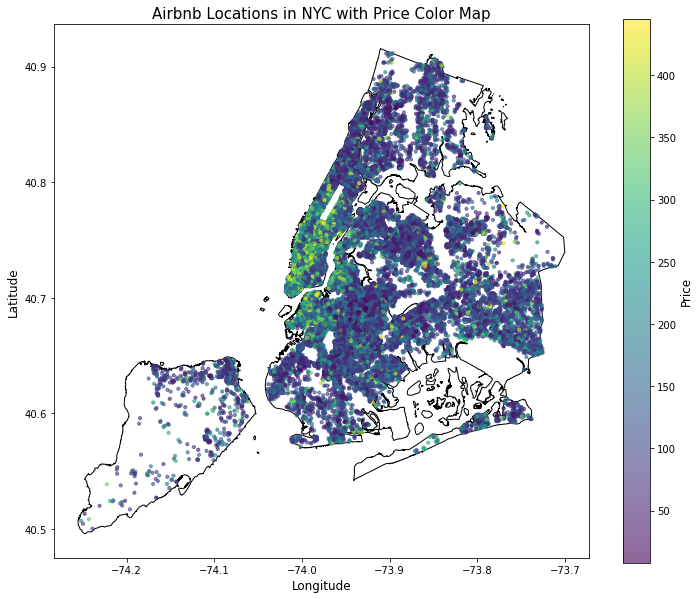

In [34]:
# Plot boroughs
fig, ax = plt.subplots(figsize=(12, 10))
boroughs.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black")

# Create Seaborn color palette for price
price_palette = sns.color_palette('viridis', as_cmap=True)

# Create scatter plot with different colors for each room type
scatter = ax.scatter(
    x=gdf_airbnb['longitude'],
    y=gdf_airbnb['latitude'],
    c=gdf_airbnb['price'],  # Color based on price
    cmap=price_palette,  # Use viridis color map
    s=10,
    alpha=0.6,
    label=gdf_airbnb['room_type']
)

# Add color bar
cbar = plt.colorbar(scatter, label='Price')
cbar.set_label('Price', fontsize=12)

# Set plot title and labels
plt.title('Airbnb Locations in NYC with Price Color Map', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

plt.show()

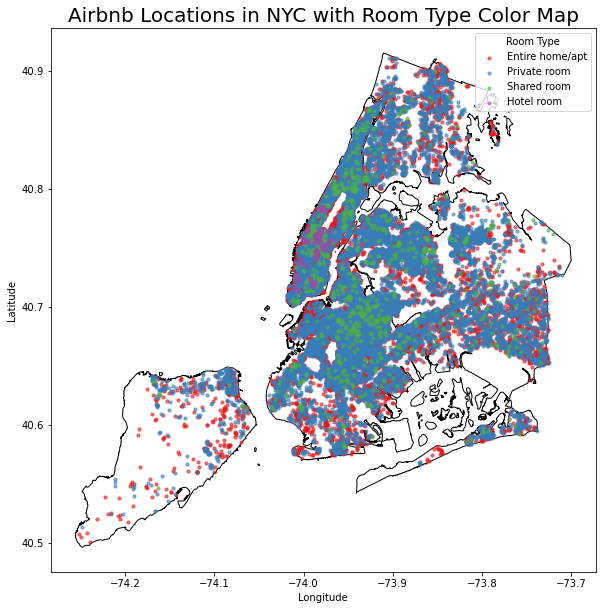

In [35]:
# Plot boroughs
fig, ax = plt.subplots(figsize=(12, 10))
boroughs.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black")

# Create Seaborn color palette for room types
room_type_palette = sns.color_palette("Set1", n_colors=len(gdf_airbnb['room_type'].unique()))

# Create scatter plot with different colors for each room type
for room_type, color in zip(gdf_airbnb['room_type'].unique(), room_type_palette):
    subset = gdf_airbnb[gdf_airbnb['room_type'] == room_type]
    subset.plot(ax=ax, markersize=10, color=color, alpha=0.6, label=room_type)

# Add legend
ax.legend(title='Room Type')

# Set plot title and labels
plt.title('Airbnb Locations in NYC with Room Type Color Map', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Borough Analysis

In [36]:
num_neighborhoods = df['neighborhood'].nunique()
num_boroughs = df['borough'].nunique()
print(f"# of neighborhoods: {num_neighborhoods}\n# of boroughs: {num_boroughs}")

# of neighborhoods: 224
# of boroughs: 5


In [37]:
df.groupby(['borough','neighborhood'])['neighborhood'].size()

borough        neighborhood 
Bronx          Allerton         83
               Baychester       57
               Belmont          59
               Bronxdale        30
               Castle Hill      14
                                ..
Staten Island  Tottenville       6
               West Brighton    40
               Westerleigh       6
               Willowbrook       2
               Woodrow           5
Name: neighborhood, Length: 224, dtype: int64

In [38]:
borough_count = df['borough'].value_counts()
print('Number of Listings in Each Borough:')
print(borough_count)

df_borough_pivot = round(df.pivot_table(values='price', index='borough', 
                                  aggfunc=['mean', 'median']).sort_values(by=('median', 'price'), ascending=False),2)
print('\nMean and Median Prices in Each Borough:')
print(df_borough_pivot)

Number of Listings in Each Borough:
Manhattan        27572
Brooklyn         23678
Queens           10468
Bronx             2556
Staten Island      632
Name: borough, dtype: int64

Mean and Median Prices in Each Borough:
                 mean median
                price  price
borough                     
Manhattan      175.78  151.0
Brooklyn       130.86  108.0
Staten Island  111.53   95.0
Queens         112.69   90.0
Bronx          106.80   88.0


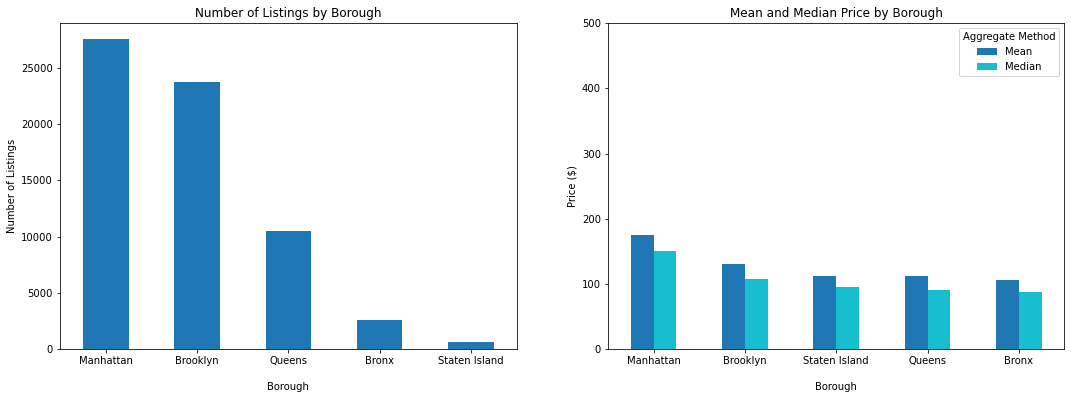

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

borough_count.plot.bar(ax=ax[0])
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=360)
ax[0].set_xlabel('\nBorough')
ax[0].set_ylabel('Number of Listings')
ax[0].set_title('Number of Listings by Borough')

df_borough_pivot.plot.bar(ax=ax[1], cmap='tab10')
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=360)
ax[1].set_xlabel('\nBorough')
ax[1].set_ylabel('Price ($)')
ax[1].set_title('Mean and Median Price by Borough')
ax[1].set_ylim(0,500)
ax[1].legend(title='Aggregate Method', labels=['Mean', 'Median'])

plt.show()

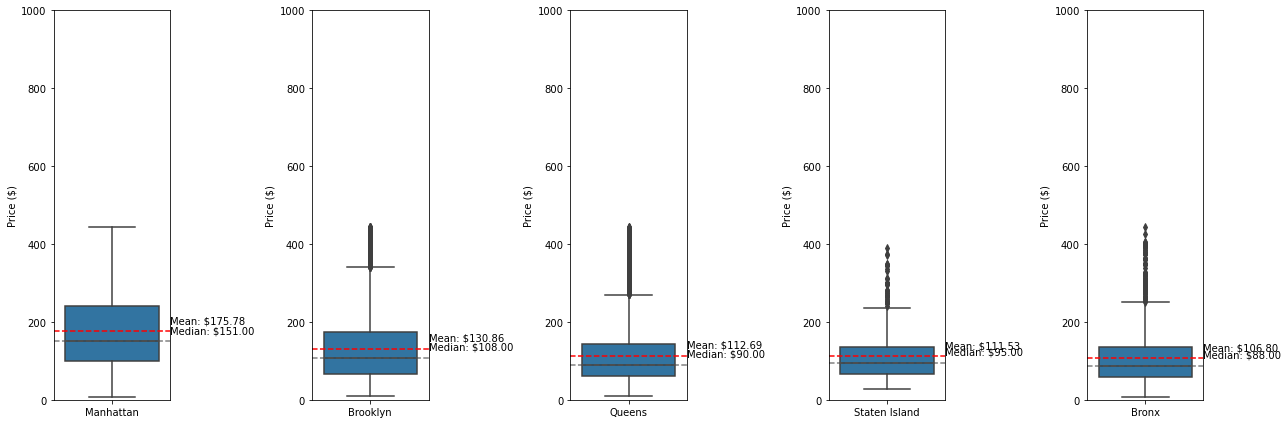

In [40]:
boroughs = df['borough'].unique()

fig, axes = plt.subplots(1, 5, figsize=(18, 6))
axes = axes.ravel()

for i, borough in enumerate(boroughs):
    ax=axes[i]
    median = df[df['borough']==borough]['price'].median()
    mean = df[df['borough']==borough]['price'].mean()
    sns.boxplot(data=df[df['borough'] == borough], x='borough', y=df['price'], ax=ax)
    ax.set_ylim(0,1000)
    ax.axhline(mean, linestyle='--', color='red')
    ax.text(0.5, mean + 20, f'Mean: ${mean:.2f}', color='black')
    ax.axhline(median, linestyle='--', color='grey')
    ax.text(0.5, median + 20, f'Median: ${median:.2f}', color='black')
    ax.set_xlabel('')
    ax.set_ylabel('Price ($)')
plt.tight_layout()
plt.show()

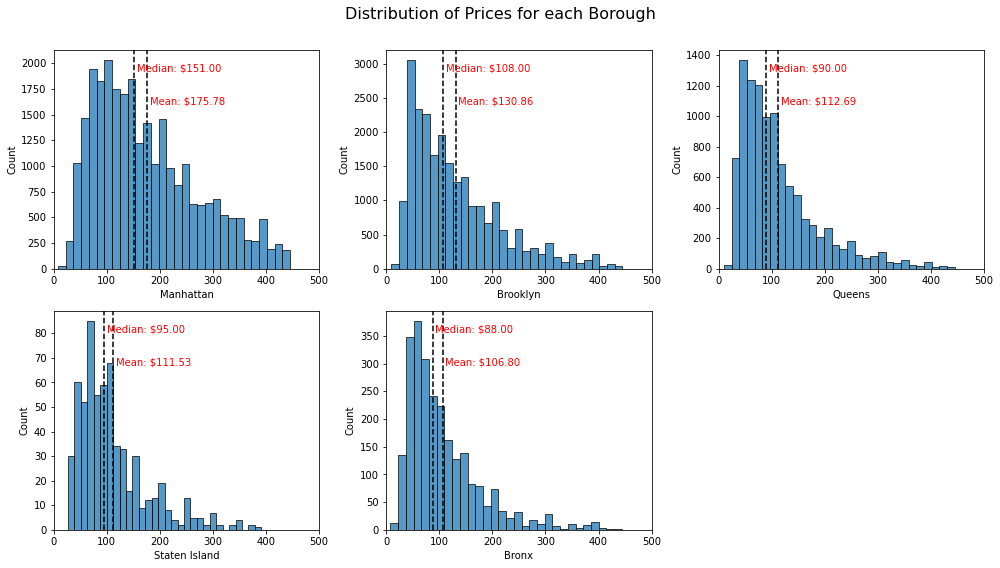

In [41]:
boroughs = df['borough'].unique()

fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes[1, 2].axis('off')
axes = axes.ravel()

for i, borough in enumerate(boroughs):
    ax=axes[i]
    median = df[df['borough']==borough]['price'].median()
    mean = df[df['borough']==borough]['price'].mean()
    sns.histplot(data=df[df['borough']==borough], x='price', bins=30, ax=ax, line_kws={'median':median})
    ax.set_xlim(0,500)
    ax.set_xlabel(borough)
    ymax = ax.get_ylim()[1]
    ax.axvline(x=median, linestyle='--', color='black')
    ax.text(median + 5, ymax * 0.9, f'Median: ${median:.2f}', color='red')
    ax.axvline(x=mean, linestyle='--', color='black')
    ax.text(mean + 5, ymax * 0.75, f'Mean: ${mean:.2f}', color='red')


plt.suptitle('Distribution of Prices for each Borough\n', fontsize=16)
plt.tight_layout()
plt.show()

### Room Type Analysis

In [42]:
df_room_type_counts = df['room_type'].value_counts()
print('Number of Listings for each Room Type')
print(df_room_type_counts)

df_room_type_pivot = round(df.pivot_table(values='price', index='room_type', 
                                    aggfunc=['mean', 'median']).sort_values(by=('mean', 'price'), ascending=False),2)
print('\nMean and Median Prices for each Room Type')
print(df_room_type_pivot)

Number of Listings for each Room Type
Entire home/apt    34126
Private room       29419
Shared room         1018
Hotel room           343
Name: room_type, dtype: int64

Mean and Median Prices for each Room Type
                   mean median
                  price  price
room_type                     
Hotel room       249.53  240.0
Entire home/apt  190.68  171.0
Private room      94.91   75.0
Shared room       81.60   60.0


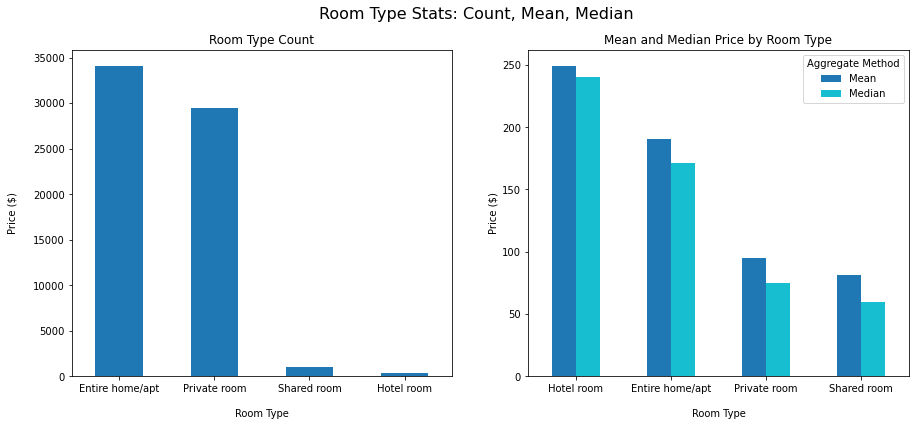

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

df_room_type_counts.plot.bar(ax=ax[0])
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(), rotation=360)
ax[0].set_xlabel('\nRoom Type')
ax[0].set_ylabel('Price ($)\n')
ax[0].set_title('Room Type Count')

df_room_type_pivot.plot.bar(ax=ax[1], cmap='tab10')
ax[1].set_xticklabels(labels=ax[1].get_xticklabels(), rotation=360)
ax[1].set_xlabel('\nRoom Type')
ax[1].set_ylabel('Price ($)')
ax[1].set_title('Mean and Median Price by Room Type')
ax[1].legend(title='Aggregate Method', labels=['Mean', 'Median'])
plt.suptitle('Room Type Stats: Count, Mean, Median', fontsize=16)
plt.show()

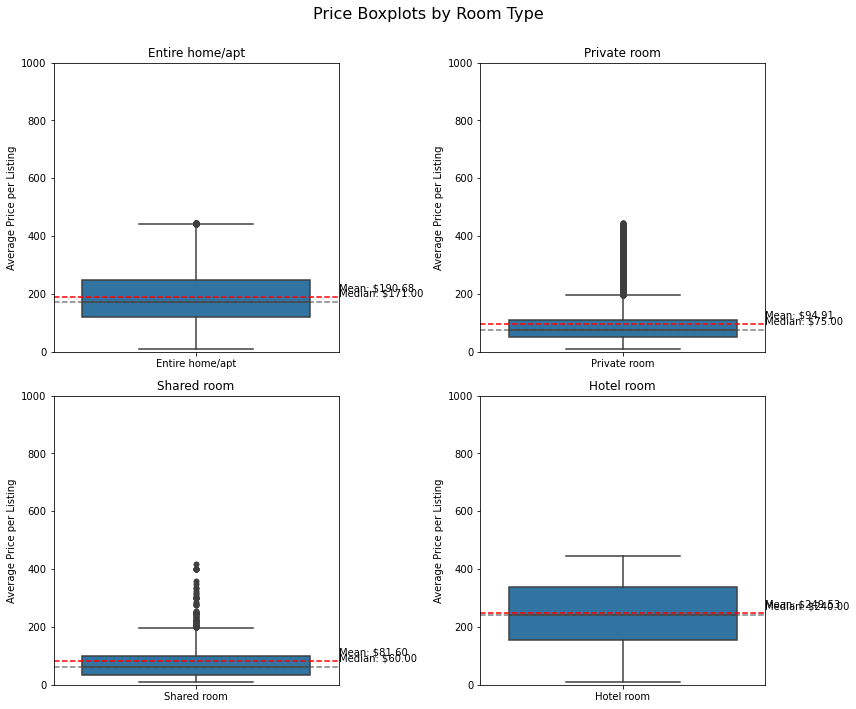

In [44]:
room_types = df['room_type'].unique()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, room_type in enumerate(room_types):
    median = df[df['room_type']==room_type]['price'].median()
    mean = df[df['room_type']==room_type]['price'].mean()
    ax = axes[i]
    sns.boxplot(x='room_type', y='price', data = df[df['room_type'] == room_type], ax=ax, flierprops=dict(marker='o'))
    ax.set_title(room_type)
    ax.axhline(mean, linestyle='--', color='red')
    ax.text(0.5, mean + 20, f'Mean: ${mean:.2f}', color='black')
    ax.axhline(median, linestyle='--', color='grey')
    ax.text(0.5, median + 20, f'Median: ${median:.2f}', color='black')
    ax.set_xlabel('')
    ax.set_ylabel('Average Price per Listing')
    ax.set_ylim(0,1000)

plt.suptitle('Price Boxplots by Room Type\n', fontsize=16)
plt.tight_layout() 
plt.show()

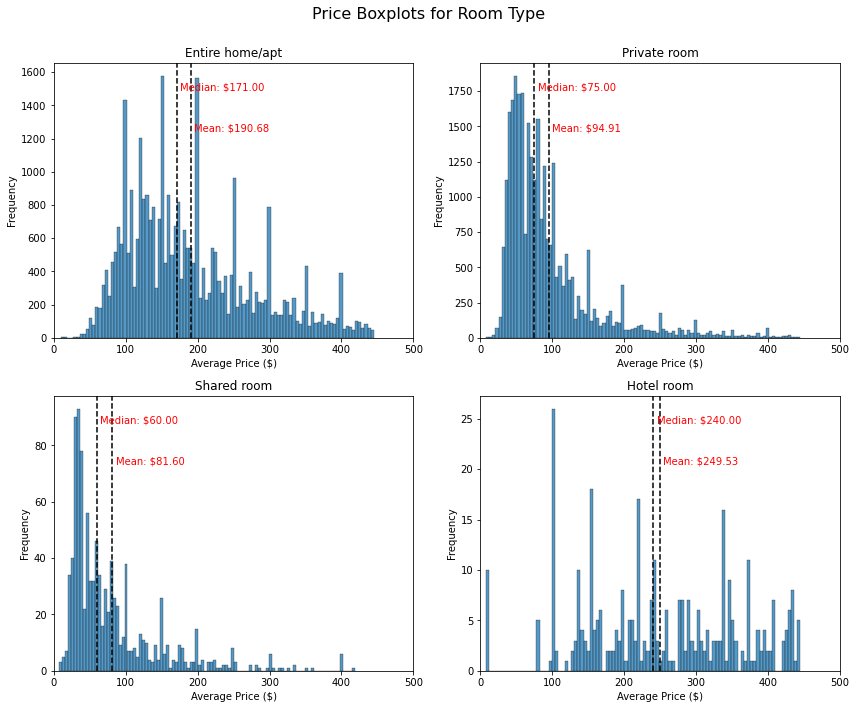

In [45]:
room_types = df['room_type'].unique()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the axes array

for i, room_type in enumerate(room_types):
    median = df[df['room_type']==room_type]['price'].median()
    mean = df[df['room_type']==room_type]['price'].mean()
    ax = axes[i]
    sns.histplot(data=df[df['room_type'] == room_type], x='price', bins=100, ax=ax, edgecolor='black')
    ax.set_xlim(0, 500)
    ax.set_title(room_type)
    ax.set_xlabel('Average Price ($)')
    ax.set_ylabel('Frequency')
    ymax = ax.get_ylim()[1]
    ax.axvline(x=median, linestyle='--', color='black')
    ax.text(median + 5, ymax * 0.9, f'Median: ${median:.2f}', color='red')
    ax.axvline(x=mean, linestyle='--', color='black')
    ax.text(mean + 5, ymax * 0.75, f'Mean: ${mean:.2f}', color='red')

plt.suptitle('Price Boxplots for Room Type\n', fontsize=16)
plt.tight_layout()
plt.show()


In [46]:
room_types

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [47]:
df = df[df['room_type'] != 'Hotel room']

## Feature Extraction

**In this section, features extraction is performed for `bathrooms_text` and `amenities` features. Feature extraction is also performed   using the `latitude`, and `longitude` features to calculate distances between transit stations as well as distances between main tourist attractions. Visualization are also created for bathroom features and amenity features.**

### Bathroom Features: 
* `shared_bathroom`
* `bathrooms`

In [48]:
df['bathrooms_text'].unique()

array(['1 bath', '1.5 baths', '1 shared bath', '1 private bath',
       'Shared half-bath', '2 baths', '3 baths', 'Half-bath',
       '2 shared baths', '1.5 shared baths', '2.5 baths',
       '0 shared baths', '4.5 baths', '2.5 shared baths', '3.5 baths',
       'Private half-bath', '0 baths', '3.5 shared baths', '4 baths',
       '3 shared baths', '11.5 shared baths', '4 shared baths',
       '4.5 shared baths', '5 baths', '6 shared baths',
       '6.5 shared baths', '5.5 baths', '5.5 shared baths', '7 baths',
       '5 shared baths', '6 baths'], dtype=object)

**The `bathroom_text` feature contains floats and the string 'shared bathroom(s)'.**

**To derive meaning from the string, I create a separate column `shared_bathroom`. Inserting a 1 for each observation implies the listing has a shared bathroom and a 0 implies the listing has a private bathroom.**

In [49]:
df = df.assign(shared_bathroom=df['bathrooms_text'].apply(lambda x: 1 if re.search(r'\bShared\b', x, re.IGNORECASE) else 0))

In [50]:
def extract_number(text):
    text = text.lower().replace('half-bath', '0.5')
    number = re.search(r'\d+(\.\d+)?', text)  # Match integers and floating-point numbers
    return float(number.group()) if number else None  # Convert to float

df = df.assign(bathrooms=df['bathrooms_text'].apply(extract_number))

In [51]:
df['bathrooms'].unique()

array([ 1. ,  1.5,  0.5,  2. ,  3. ,  2.5,  0. ,  4.5,  3.5,  4. , 11.5,
        5. ,  6. ,  6.5,  5.5,  7. ])

In [52]:
df.loc[(df['bathrooms_text'] == 'Half-bath') | 
       (df['bathrooms_text'] == 'Shared half-bath') | 
       (df['bathrooms_text'] == 'Private half-bath')][['bathrooms_text', 'shared_bathroom', 'bathrooms']]

,bathrooms_text,shared_bathroom,bathrooms
28,Shared half-bath,1,0.5
56,Half-bath,0,0.5
470,Shared half-bath,1,0.5
487,Shared half-bath,1,0.5
880,Half-bath,0,0.5
...,...,...,...
69954,Shared half-bath,1,0.5
70012,Shared half-bath,1,0.5
70288,Shared half-bath,1,0.5
70302,Private half-bath,0,0.5


In [53]:
df = df.drop(columns=['bathrooms_text'])

In [54]:
shared_bathrooms_count = df['shared_bathroom'].value_counts()
print('Shared Bathroom Count (0 = Private, 1 = Shared)')
print(shared_bathrooms_count)

bathrooms_count = df['bathrooms'].value_counts().sort_index()
print('\nNumber of Bathrooms Count')
print(bathrooms_count)

Shared Bathroom Count (0 = Private, 1 = Shared)
0    46004
1    18559
Name: shared_bathroom, dtype: int64

Number of Bathrooms Count
0.0      1462
0.5       154
1.0     52370
1.5      2852
2.0      6378
2.5       538
3.0       565
3.5        57
4.0       132
4.5        12
5.0        29
5.5         6
6.0         5
6.5         1
7.0         1
11.5        1
Name: bathrooms, dtype: int64


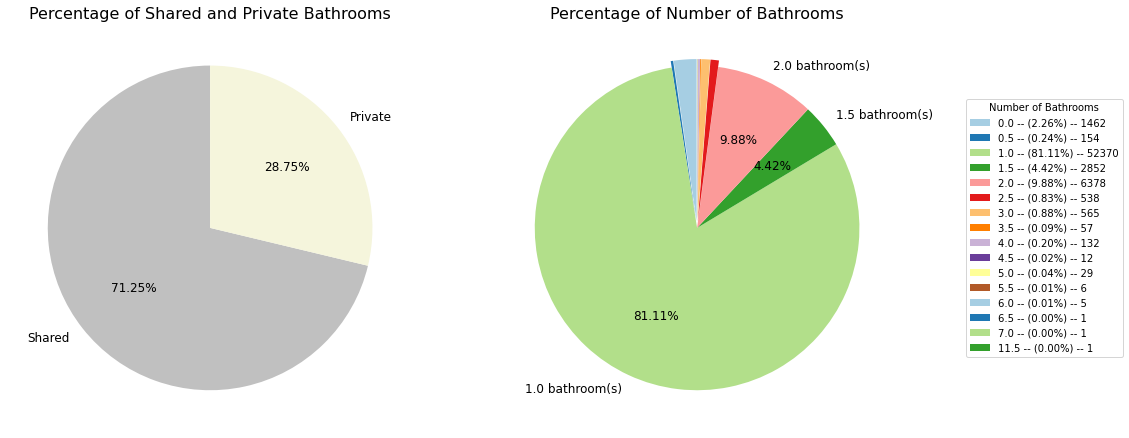

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First Pie Chart for Shared and Private Bathrooms
axes[0].pie(
    shared_bathrooms_count, labels=['Shared', 'Private'], startangle=90,
    autopct='%1.2f%%', colors=['silver', 'beige'],textprops={'fontsize': 12}
)
axes[0].set_title('Percentage of Shared and Private Bathrooms', fontdict={'fontsize': 16})

# ---------------------------------------------------------------------------
# Second Pie Chart for Number of Bathrooms

# Calculations for pie chart labels and explode
percentages = bathrooms_count / bathrooms_count.sum()
labels = bathrooms_count.index
show_labels = percentages > 0.04

# Explode slices with percentages less than 4%
small_slices = bathrooms_count[percentages < 0.04]
explode = [0.04 if index in small_slices.index else 0 for index in bathrooms_count.index]

wedges, texts, autotexts = axes[1].pie(
    bathrooms_count, labels=[f'{label} bathroom(s)' if show else '' for label, show in zip(labels, show_labels)],
    autopct=lambda p: f'{p:.2f}%' if p > 4 else '',
    explode=explode, startangle=90, colors=plt.cm.Paired.colors, textprops={'fontsize': 12})

# Add legend with corresponding percentages and counts
legend_labels = [f'{label} -- ({bathrooms_count[label] / bathrooms_count.sum():.2%}) -- {bathrooms_count[label]}'
                 for label in bathrooms_count.index]
axes[1].legend(wedges, legend_labels, title='Number of Bathrooms', loc='center left', bbox_to_anchor=(1.15, 0, 1, 1))

axes[1].set_title('Percentage of Number of Bathrooms', fontdict={'fontsize': 16})

plt.show()

### Amenities Features: 
* `has_ac`
* `has_heating`
* `has_wifi`
* `has_essentials`
* `has_kitchen`
* `has_television`
* `has_washer`
* `has_safety`
* `has_workspace`
* `children_friendly`
* `pet_friendly`
* `has_gym`
* `has_pool`
* `has_fireplace`
* `has_views`
* `has_parking`

In [56]:
df_amenities = df.copy()

def amenities_breakdown(amenities_list):
    return ast.literal_eval(amenities_list)

df_amenities['amenities'] = df['amenities'].apply(amenities_breakdown)

df_explode = df_amenities.explode('amenities')
print('Length of df_explode: ', len(df_explode))
print('Number of unique amenities: ', df_explode['amenities'].nunique())

Length of df_explode:  1677512
Number of unique amenities:  10598


In [57]:
top_50 = df_explode['amenities'].value_counts().head(50)
top_50

Wifi                            59935
Smoke alarm                     58349
Kitchen                         56687
Carbon monoxide alarm           50237
Essentials                      46919
Air conditioning                44025
Hot water                       42217
Hangers                         41996
Heating                         40499
Hair dryer                      37575
Iron                            36672
Dishes and silverware           36481
Refrigerator                    35631
TV                              35294
Cooking basics                  34479
Bed linens                      32723
Microwave                       32315
Dedicated workspace             31943
Shampoo                         31875
Fire extinguisher               28387
Self check-in                   25214
First aid kit                   25063
Long term stays allowed         23490
Oven                            23458
Free street parking             23028
Coffee maker                    20710
Extra pillow

In [58]:
ac_keywords = ['AC', 'air conditioning'] 
df['has_air_conditioning'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in ac_keywords) else 0)

df['has_heating'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bHeating\b', x, re.IGNORECASE) else 0)

wifi_keywords = ['wifi', 'ethernet']
df['has_wifi'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in wifi_keywords) else 0)

essentials_keywords = ['essentials', 'toilet paper', 'hand soap', 'body soap', 'towel', 'pillow', 'per guest', 'linens']
df['has_essentials'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in essentials_keywords) else 0)

df['has_kitchen'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bkitchen\b', x, re.IGNORECASE) else 0)

tv_keywords = ['TV', 'cable']
df['has_television'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in tv_keywords) else 0)

df['has_washer'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bWasher\b', x, re.IGNORECASE) else 0)

safety_keywords = ['security alarm', 'smoke alarm', 'carbon monoxide alarm', 'fire extinguisher', 'first-aid kit']
df['has_safety'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in safety_keywords) else 0)

workspace_keywords = ['office', 'workspace', 'work', 'remote']
df['has_workspace'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in workspace_keywords) else 0)

children_keywords = ['high chair', 'crib', 'baby safety gates']
df['children_friendly'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in children_keywords) else 0)

pet_keywords = ['furniture covers', 'bowls for pet food and water', 'pet', 'pets', 'dog', 'cat']
df['pet_friendly'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in pet_keywords) else 0)

gym_keywords = ['gym', 'fitness equipment', 'exercise', 'weight', 'training']
df['has_gym'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in gym_keywords) else 0)

df['has_pool'] = df['amenities'].apply(lambda x: 1 if re.search(r'\bpool\b', x, re.IGNORECASE) else 0)

fireplace_keywords = ['fireplace', 'pit']
df['has_fireplace'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in fireplace_keywords) else 0)

views_keywords = ['city views', 'city skyline view', 'skyline', 'views', 'cityscape']
df['has_views'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in views_keywords) else 0)

parking_keywords = ['parking', 'garage', 'car']
df['has_parking'] = df['amenities'].apply(lambda x: 1 if any(re.search(r'\b{}\b'.format(keyword), x, re.IGNORECASE) for keyword in parking_keywords) else 0)

In [59]:
df = df.drop(columns='amenities')

In [60]:
amenities = df.iloc[:, -16:]

amenity_labels = [amenity for amenity in amenities.columns]

amenities_value_counts = []

for i, amenity in enumerate(amenities):
    value_counts = df[amenity].value_counts()
    value_counts.name = value_counts.name.replace('has_', ' ').replace('_', ' ').title()
    amenities_value_counts.append(value_counts)
    

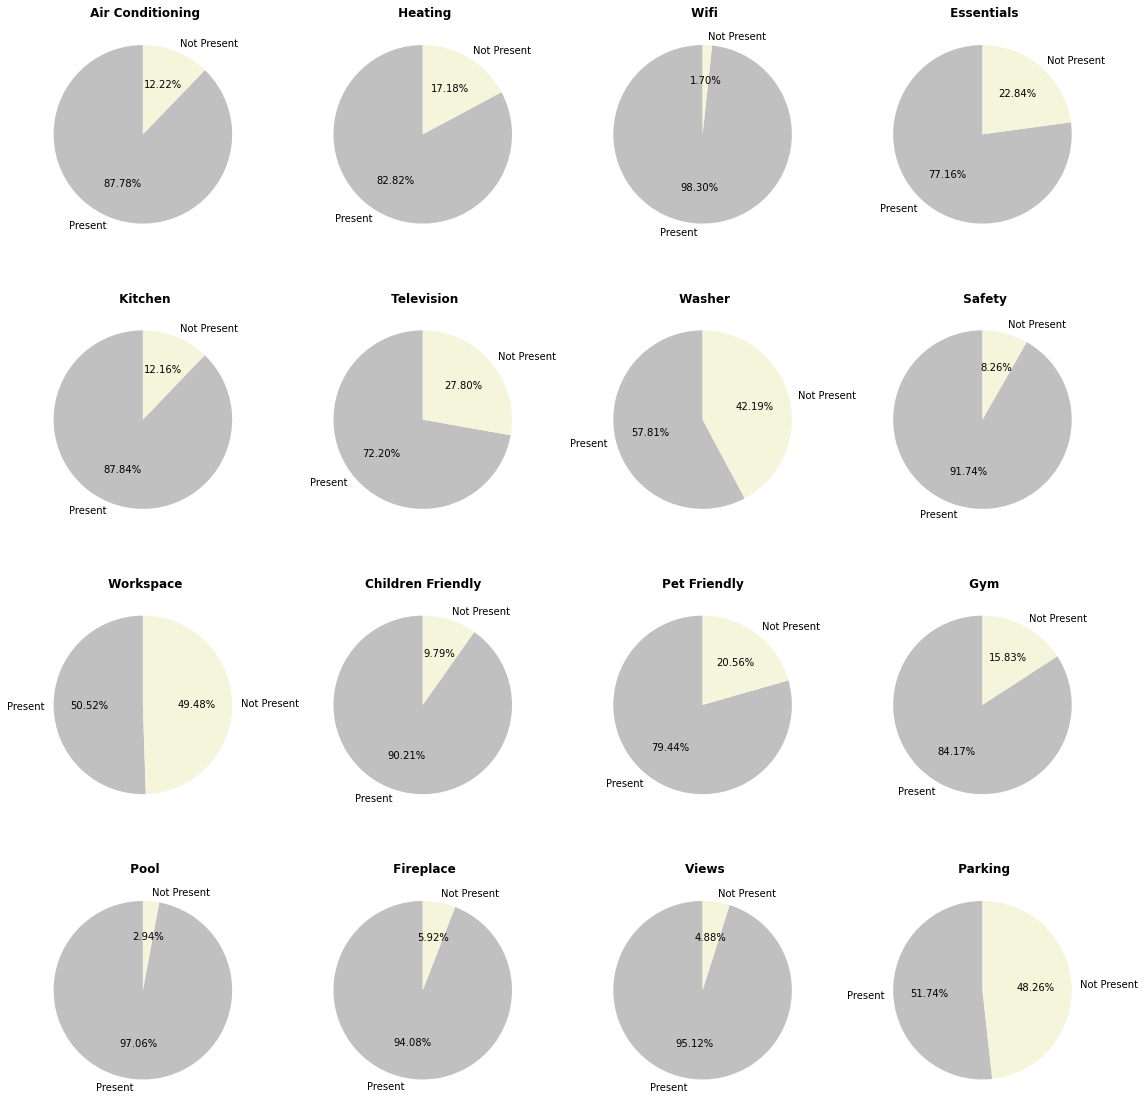

In [61]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
axes = axes.ravel()

for i, amenity in enumerate(amenities_value_counts):
    ax=axes[i]
    ax.pie(amenity, autopct='%1.2f%%', startangle=90,
           colors=['silver', 'beige'], labels=['Present', 'Not Present'])
    ax.set_title(amenity.name, fontdict={'fontweight':'bold'})
    
plt.tight_layout()
plt.show()

### Transit and Tourist Attraction Features

The Airbnb dataset provides latitude and longitude coordinates that are utilized to create maps with highlighted features. Using these coordinates, the distances between each Airbnb property and the five highest Google reviewed attractions below are calculated:
* Central Park
* Times Square
* Empire State Building
* Statue of Liberty
* Bryant Park

 The feature `nearest_attraction_mi` is extracted with distances of 10 main tourist attractions. Also using the Airbnb coordinates, another feature `nearest_transit_mi` is extracted using additional data from the Metropolitan Transportation Authority (MTA) to calculate the distance between the property and the nearest transit station. 

In [62]:
attractions = {
    "Central Park": (40.782555, -73.968164),
    "Times Square": (40.757974, -73.988123),
    "Empire State Building": (40.748440, -73.990273),
    "Statue of Liberty": (40.702960, -74.018258),
    "Bryant Park": (40.753537, -73.985533)
}

# Function to compute Haversine (Great-Circle) distance
def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two lat/lon points."""
    return great_circle((lat1, lon1), (lat2, lon2)).miles

# Calculate distance for each attraction
for name, (lat2, lon2) in attractions.items():
    df[name + " Distance (mi)"] = df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], lat2, lon2), axis=1
    )

# Display the updated DataFrame
df

,id,last_scraped,host_acceptance_rate,host_is_superhost,host_total_listings_count,neighborhood,borough,latitude,longitude,property_type,...,has_gym,has_pool,has_fireplace,has_views,has_parking,Central Park Distance (mi),Times Square Distance (mi),Empire State Building Distance (mi),Statue of Liberty Distance (mi),Bryant Park Distance (mi)
0,2595,2024-03-08,94.0,f,9.0,Midtown,Manhattan,40.753560,-73.985590,Entire rental unit,...,0,0,0,0,1,2.201133,0.332547,0.430381,3.892131,0.003380
1,5121,2024-03-08,94.0,f,2.0,Bedford-Stuyvesant,Brooklyn,40.685350,-73.955120,Private room in rental unit,...,0,0,0,0,0,6.750857,5.307110,4.731889,3.524287,4.973185
2,5136,2023-03-06,94.0,f,5.0,Sunset Park,Brooklyn,40.662650,-73.994540,Entire rental unit,...,0,0,0,0,0,8.398987,6.594831,5.931737,3.049827,6.297388
3,5178,2023-03-07,100.0,f,1.0,Midtown,Manhattan,40.764570,-73.983170,Private room in rental unit,...,0,0,0,0,1,1.469922,0.524298,1.174845,4.636323,0.772274
4,5203,2023-03-06,94.0,f,5.0,Upper West Side,Manhattan,40.803800,-73.967510,Private room in rental unit,...,0,0,0,0,1,1.468288,3.344896,4.006148,7.456510,3.598586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70984,1366767632362362078,2025-03-02,80.0,t,4.0,Bedford-Stuyvesant,Brooklyn,40.685503,-73.919512,Private room in rental unit,...,0,0,0,0,0,7.173147,6.162873,5.713284,5.311705,5.835195
70985,1366771750105846963,2025-03-02,80.0,t,4.0,Bedford-Stuyvesant,Brooklyn,40.685503,-73.919512,Private room in rental unit,...,0,0,0,0,0,7.173147,6.162873,5.713284,5.311705,5.835195
70986,1366773325407097923,2025-03-02,80.0,t,4.0,Bedford-Stuyvesant,Brooklyn,40.685503,-73.919512,Private room in rental unit,...,0,0,0,0,0,7.173147,6.162873,5.713284,5.311705,5.835195
70987,1366845814698104281,2025-03-02,94.0,f,10.0,Upper West Side,Manhattan,40.801312,-73.965916,Shared room in rental unit,...,0,0,0,0,0,1.301308,3.211874,3.869023,7.326938,3.456823


In [63]:
airbnb_df = df[['latitude', 'longitude']].copy()
airbnb_df = airbnb_df.drop_duplicates(subset=['latitude', 'longitude']).reset_index()
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61623 entries, 0 to 61622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      61623 non-null  int64  
 1   latitude   61623 non-null  float64
 2   longitude  61623 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.4 MB


In [64]:
airbnb_df = df[['latitude', 'longitude']].copy()
airbnb_df = airbnb_df.drop_duplicates(subset=['latitude', 'longitude'])

# Convert latitude and longitude to radians for harvesine distances
airbnb_df['lat_rad'] = airbnb_df['latitude'].apply(radians)
airbnb_df['lon_rad'] = airbnb_df['longitude'].apply(radians)

airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61623 entries, 0 to 70988
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   61623 non-null  float64
 1   longitude  61623 non-null  float64
 2   lat_rad    61623 non-null  float64
 3   lon_rad    61623 non-null  float64
dtypes: float64(4)
memory usage: 2.4 MB


In [65]:
# Load csv file of metro and bus station coordinates of NYC, Convert coordinates to radians
metro_df = pd.read_csv('metro_data.csv')
staten_df = pd.read_csv('staten_stops.txt')
transit_df = pd.concat([metro_df, staten_df])
transit_df['lat_rad'] = transit_df['stop_lat'].apply(radians)
transit_df['lon_rad'] = transit_df['stop_lon'].apply(radians)

# Load csv file of top 10 tourist attraction coordinates of NYC, Convert coordinates to radians
attractions_df = pd.read_csv('tourist_attractions.csv')
attractions_df['lat_rad'] = attractions_df['Latitude'].apply(radians)
attractions_df['lon_rad'] = attractions_df['Longitude'].apply(radians)

earth_radius_mi = 3963.1906

# Calculate haversine distances for transit
distances_transit = haversine_distances(transit_df[['lat_rad', 'lon_rad']].values,
                                airbnb_df[['lat_rad', 'lon_rad']].values) * earth_radius_mi

# Extract minimum transit distance, Store it as a DataFrame
nearest_transit = distances_transit.min(axis=0)
nearest_transit_df = pd.DataFrame(nearest_transit, columns=['nearest_transit'])

# Calculate haversine distances for attractions
distances_attractions = haversine_distances(attractions_df[['lat_rad', 'lon_rad']].values,
                                airbnb_df[['lat_rad', 'lon_rad']].values) * earth_radius_mi

# Extract minimum attraction distance, Store it as a DataFrame
nearest_attraction = distances_attractions.min(axis=0)
nearest_attractions_df = pd.DataFrame(nearest_attraction, columns=['nearest_attraction'])

# Reset airbnb_df index and add minimum distances for transit and attractions
airbnb_df = airbnb_df.reset_index()
airbnb_df['nearest_transit_mi'] = nearest_transit_df
airbnb_df['nearest_attraction_mi'] = nearest_attractions_df
airbnb_df.columns

Index(['index', 'latitude', 'longitude', 'lat_rad', 'lon_rad',
       'nearest_transit_mi', 'nearest_attraction_mi'],
      dtype='object')

In [66]:
# Merge airbnb_df with the df using the common columns 'latitude' and 'longitude'
airbnb_df = airbnb_df.drop(columns=['index', 'lat_rad', 'lon_rad'])
df = pd.merge(df, airbnb_df, how='left', on=['latitude', 'longitude'])

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64563 entries, 0 to 64562
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   64563 non-null  int64  
 1   last_scraped                         64563 non-null  object 
 2   host_acceptance_rate                 64563 non-null  float64
 3   host_is_superhost                    64563 non-null  object 
 4   host_total_listings_count            64563 non-null  float64
 5   neighborhood                         64563 non-null  object 
 6   borough                              64563 non-null  object 
 7   latitude                             64563 non-null  float64
 8   longitude                            64563 non-null  float64
 9   property_type                        64563 non-null  object 
 10  room_type                            64563 non-null  object 
 11  accommodates                

## Feature Importance & Feature Selection

In this section, I first **label encode** and **one hot encode** categorical features. 

I then create a **Correlation Heatmap** of all the features to visually compare which features are more correlated with the `price` feature. I select features that have a correlation coefficient with the `price` feature of |±0.10|. I run a **second Correlation Heatmap** to have a bigger picture of which features were selected. Afterwards, I conduct a **p-value analysis** at the α = 0.05 level to confirm that the features selected show feature importance.

Lastly, I create **two OLS Regressions** with the selected features but with different outcome features: **`price` and `log_price`**. The purpose is to compare the R2 values of each regression to see **whether there is a benefit of applying the natural logarithmic function to the `price` feature.**

In [68]:
df.columns

Index(['id', 'last_scraped', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'neighborhood', 'borough', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'shared_bathroom',
       'bathrooms', 'has_air_conditioning', 'has_heating', 'has_wifi',
       'has_essentials', 'has_kitchen', 'has_television', 'has_washer',
       'has_safety', 'has_workspace', 'children_friendly', 'pet_friendly',
       'has_gym', 'has_pool', 'has_fireplace', 'has_views', 'has_parking',
       'Central Park Distance (mi)', 'Times Square Distance (mi)',
       'Empire State Building Distance (mi)',
       'Statue of Liberty Distance (mi)', 'Bryant Park Distance (mi)',
       'nearest_transit_mi', 'nearest_attraction_mi'],
      dtype='object')

### Label Encoding
As shown four cells below, all of the label encoded features and one-hot encoded features were transformed properly.

In [69]:
le = LabelEncoder()

object_cols = ['host_is_superhost', 'instant_bookable', 'neighborhood', 'borough', 'room_type']

print('Label Encoder Transformation')
for col in object_cols :
    df[col] = le.fit_transform(df[col])
    print(col,':',df[col].unique(),'=',le.inverse_transform(df[col].unique())) 

Label Encoder Transformation
host_is_superhost : [0 1] = ['f' 't']
instant_bookable : [0 1] = ['f' 't']
neighborhood : [130  13 193 205 204 185 217  63  82  97  96  28  76  66 120  93 122  34
  42 209 223 115 212  31 154  62 161 192 189 137 133  87  56 128 169 108
  25  77 219  36  94  40  67  53 148 114   4 107  59 171  75  81 140  19
 203  91   0  65 191 178  72  83  17 179 167 207  43 162  88  70 200 194
 166 208 111 118 181  11 126 187  22  23 106   6 201  44 146  79 197 147
  46  54 125  61  47 127  45  55  37   7 150  86  48 165  30 158  78   3
 121 163 216 182 220 155  24 153   8  20  39  80  41  49 104 139 131 141
  26  38  74 117 202 164 184 113 112  15 157  64  51 186 199 109 210 123
 124  57 101  99 172  33 102 116 105  84  92 156 180 170 136  95 134 188
  69 143  10 132  29 177  18  73 190 168  60  50 174 103  98 183   5 129
  71 151   2 176 135 215  68 152 149 138 195 142 213 206 173 221  90 144
 159  52  16  12 218  58 145 196 211 119   1 110 175 160  27  32  14  85
 214 

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64563 entries, 0 to 64562
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   64563 non-null  int64  
 1   last_scraped                         64563 non-null  object 
 2   host_acceptance_rate                 64563 non-null  float64
 3   host_is_superhost                    64563 non-null  int64  
 4   host_total_listings_count            64563 non-null  float64
 5   neighborhood                         64563 non-null  int64  
 6   borough                              64563 non-null  int64  
 7   latitude                             64563 non-null  float64
 8   longitude                            64563 non-null  float64
 9   property_type                        64563 non-null  object 
 10  room_type                            64563 non-null  int64  
 11  accommodates                

In [71]:
df.columns

Index(['id', 'last_scraped', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'neighborhood', 'borough', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'review_scores_rating', 'instant_bookable', 'shared_bathroom',
       'bathrooms', 'has_air_conditioning', 'has_heating', 'has_wifi',
       'has_essentials', 'has_kitchen', 'has_television', 'has_washer',
       'has_safety', 'has_workspace', 'children_friendly', 'pet_friendly',
       'has_gym', 'has_pool', 'has_fireplace', 'has_views', 'has_parking',
       'Central Park Distance (mi)', 'Times Square Distance (mi)',
       'Empire State Building Distance (mi)',
       'Statue of Liberty Distance (mi)', 'Bryant Park Distance (mi)',
       'nearest_transit_mi', 'nearest_attraction_mi'],
      dtype='object')

In [72]:
# Shift 'price' feature to the end of the DataFrame for correlation analysis
col = df.pop('price')
df.insert(43, col.name, col)

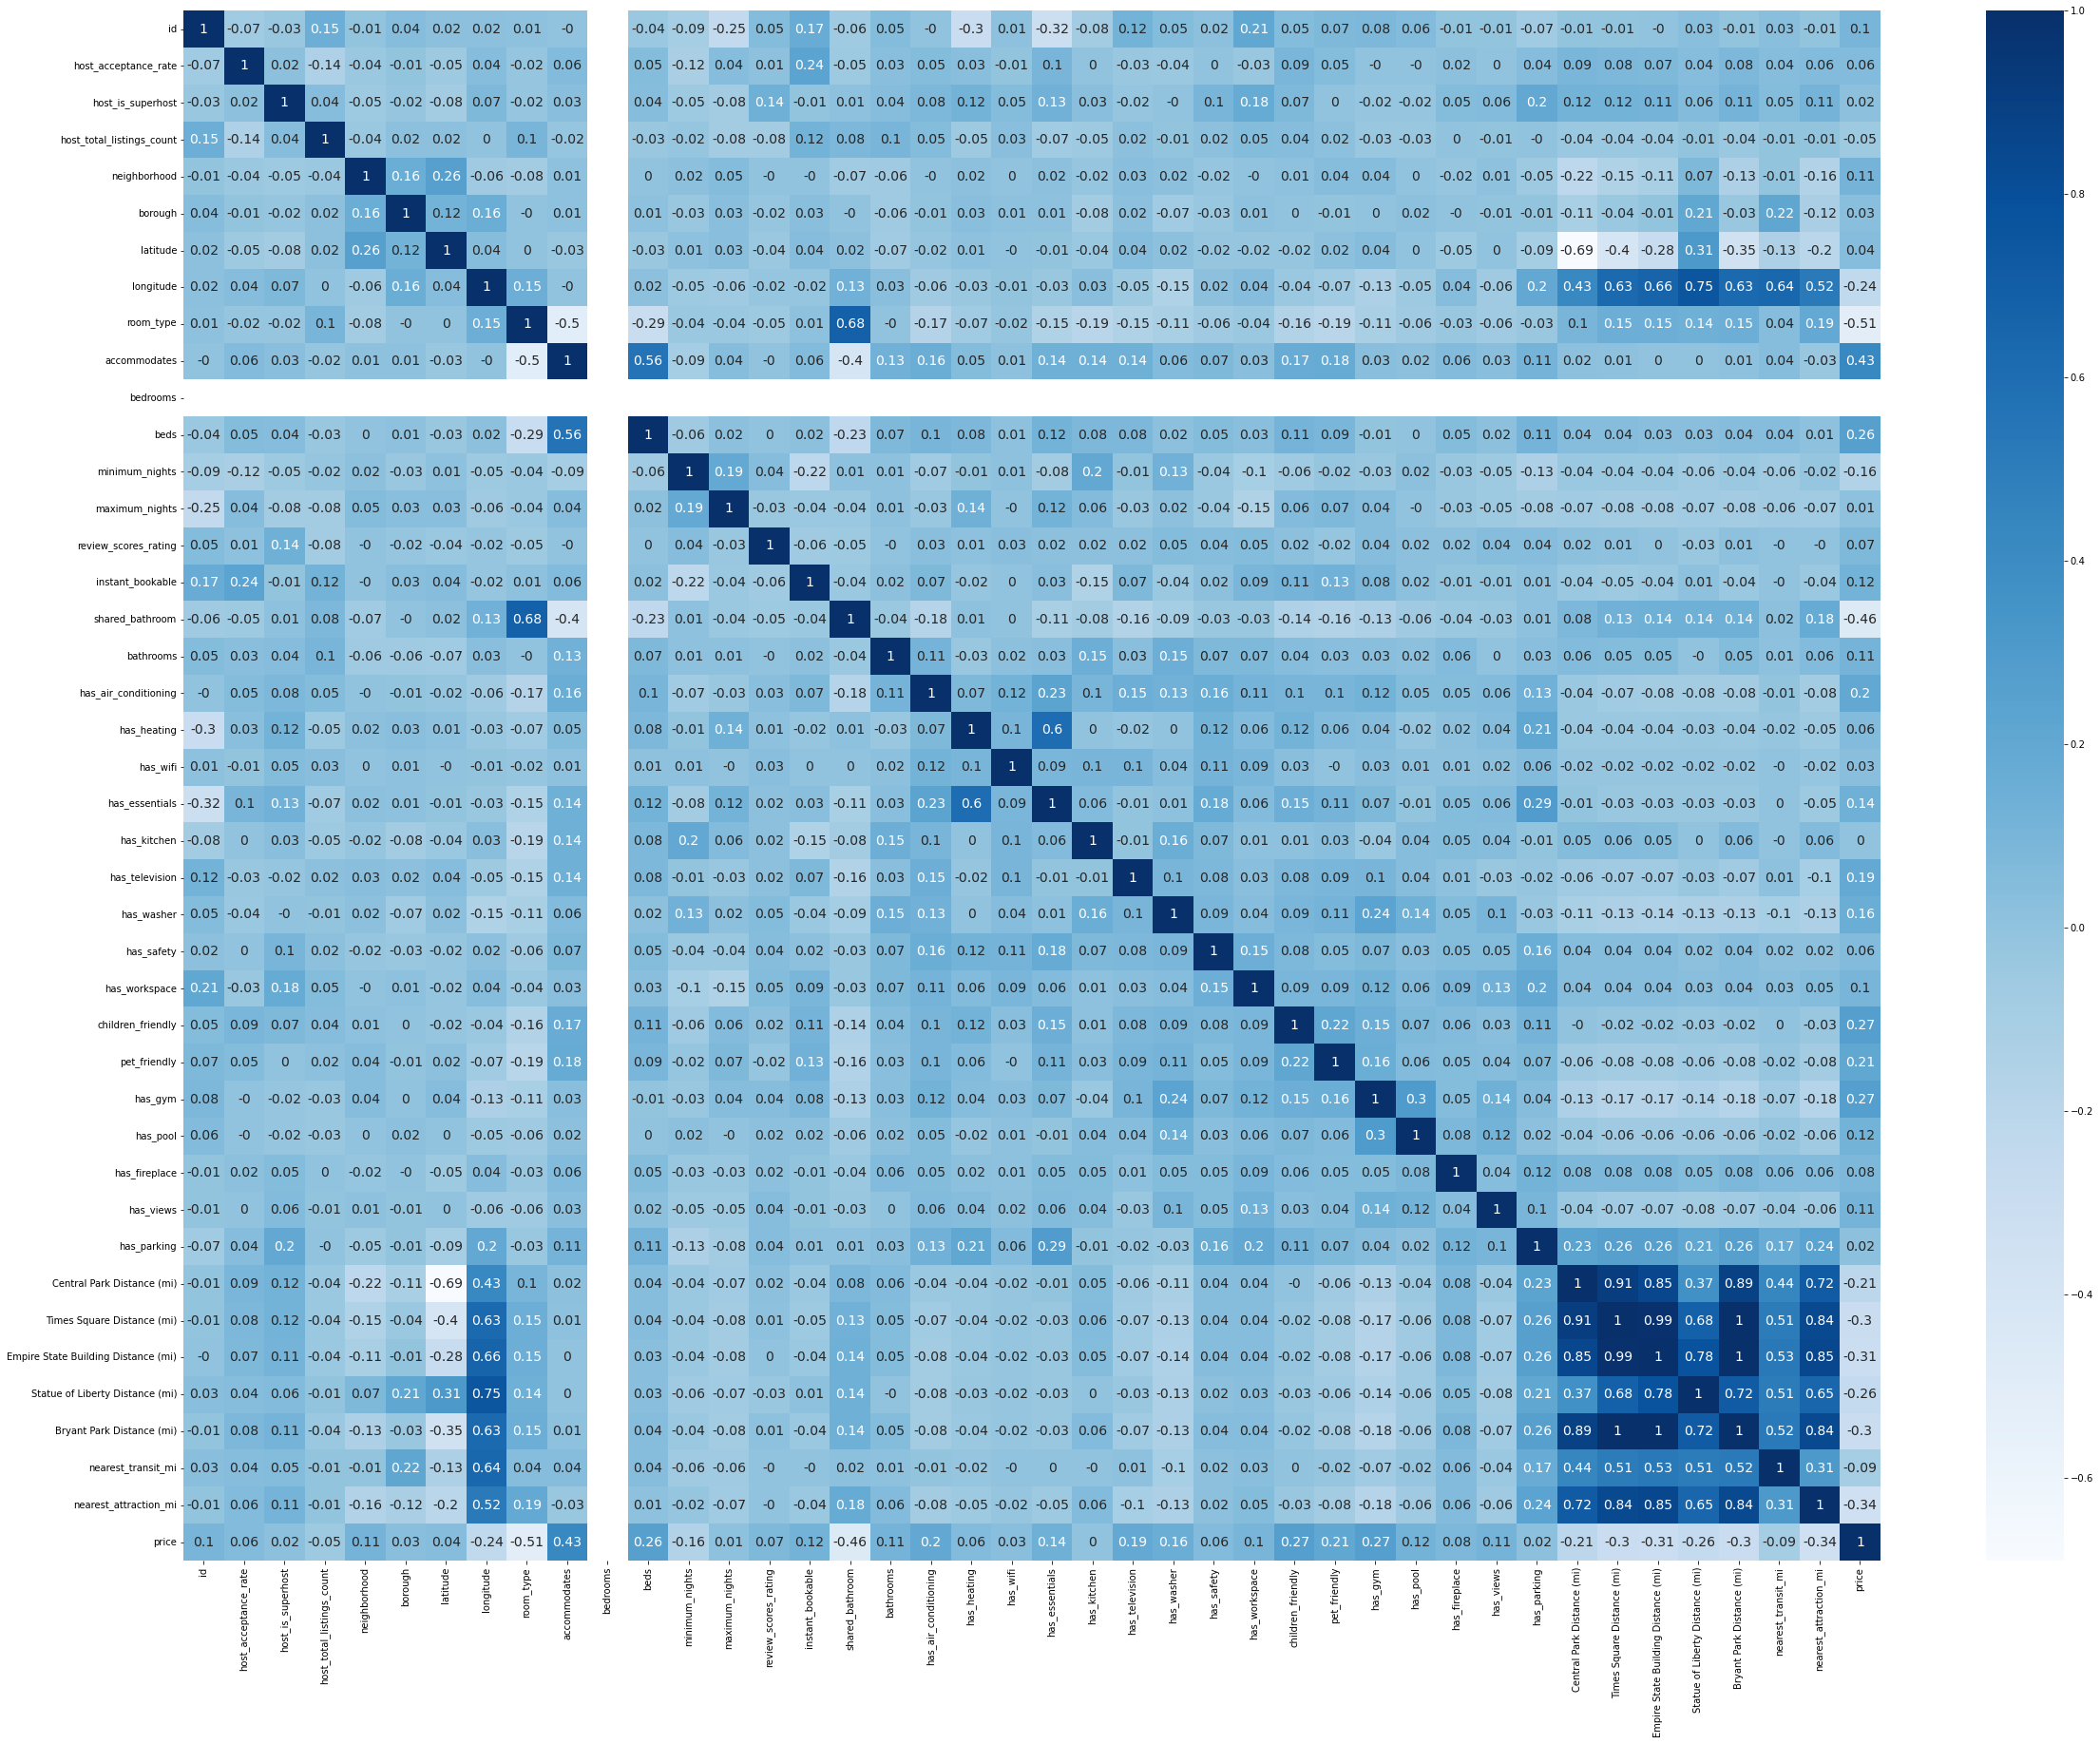

In [73]:
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, annot_kws={'fontsize': 14})
plt.show()

In [74]:
correlated_features=[]
for col in correlation_matrix.columns:
    correlation = correlation_matrix.loc[col, 'price']
    if abs(correlation) >= 0.06:
        correlated_features.append(col)

In [75]:
correlated_features

['id',
 'host_acceptance_rate',
 'neighborhood',
 'longitude',
 'room_type',
 'accommodates',
 'beds',
 'minimum_nights',
 'review_scores_rating',
 'instant_bookable',
 'shared_bathroom',
 'bathrooms',
 'has_air_conditioning',
 'has_heating',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'Central Park Distance (mi)',
 'Times Square Distance (mi)',
 'Empire State Building Distance (mi)',
 'Statue of Liberty Distance (mi)',
 'Bryant Park Distance (mi)',
 'nearest_transit_mi',
 'nearest_attraction_mi',
 'price']

In [76]:
X = df[[
 'neighborhood',
 'room_type',
 'accommodates',
 'beds',
 'minimum_nights',
 'review_scores_rating',
 'instant_bookable',
 'shared_bathroom',
 'bathrooms',
 'has_air_conditioning',
 'has_heating',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'Central Park Distance (mi)',
 'Times Square Distance (mi)',
 'Empire State Building Distance (mi)',
 'Statue of Liberty Distance (mi)',
 'Bryant Park Distance (mi)',
 'nearest_transit_mi',
 'nearest_attraction_mi'
 ]]

y = df['price']

# Add a constant term to the features matrix
X = sm.add_constant(X)

# Fit the multivariate linear regression model
price_model = sm.OLS(y, X).fit()

In [77]:
print(price_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     2145.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:11:40   Log-Likelihood:            -3.6190e+05
No. Observations:               64563   AIC:                         7.239e+05
Df Residuals:                   64533   BIC:                         7.241e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [78]:
df['log_price'] = np.log(df['price'])

In [79]:
X = df[[
 'neighborhood',
 'room_type',
 'accommodates',
 'beds',
 'minimum_nights',
 'review_scores_rating',
 'instant_bookable',
 'shared_bathroom',
 'bathrooms',
 'has_air_conditioning',
 'has_heating',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'Central Park Distance (mi)',
 'Times Square Distance (mi)',
 'Empire State Building Distance (mi)',
 'Statue of Liberty Distance (mi)',
 'Bryant Park Distance (mi)',
 'nearest_transit_mi',
 'nearest_attraction_mi'
]]

y = df['log_price']

# Add a constant term to the features matrix
X = sm.add_constant(X)

# Fit the multivariate linear regression model
log_price_model = sm.OLS(y, X).fit()

In [80]:
print(log_price_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     2996.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:11:40   Log-Likelihood:                -35908.
No. Observations:               64563   AIC:                         7.188e+04
Df Residuals:                   64533   BIC:                         7.215e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

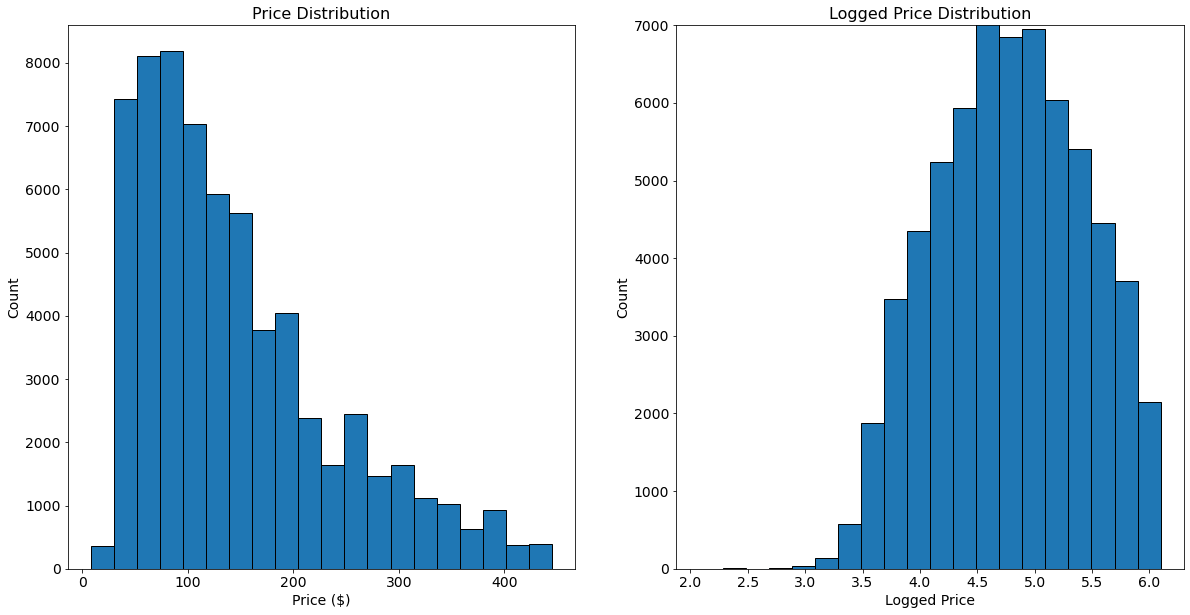

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(df['price'], bins=20, edgecolor='black')
ax[0].set_title('Price Distribution', fontsize=16)
ax[0].set_xlabel('Price ($)', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)


ax[1].hist(df['log_price'], bins=20, edgecolor='black')
ax[1].set_title('Logged Price Distribution', fontsize=16)
ax[1].set_xlabel('Logged Price', fontsize=14)
ax[1].set_ylabel('Count', fontsize=14)
ax[1].set_ylim(0,7000)
ax[1].tick_params(axis='both', which='major', labelsize=14)


plt.show()

In [82]:
features = [
 'neighborhood',
 'room_type',
 'accommodates',
 'beds',
 'minimum_nights',
 'review_scores_rating',
 'instant_bookable',
 'shared_bathroom',
 'bathrooms',
 'has_air_conditioning',
 'has_heating',
 'has_essentials',
 'has_television',
 'has_washer',
 'has_safety',
 'has_workspace',
 'children_friendly',
 'pet_friendly',
 'has_gym',
 'has_pool',
 'has_fireplace',
 'has_views',
 'Central Park Distance (mi)',
 'Times Square Distance (mi)',
 'Empire State Building Distance (mi)',
 'Statue of Liberty Distance (mi)',
 'Bryant Park Distance (mi)',
 'nearest_transit_mi',
 'nearest_attraction_mi']

X = df[features]
y = df.log_price

In [83]:
X.describe()

,neighborhood,room_type,accommodates,beds,minimum_nights,review_scores_rating,instant_bookable,shared_bathroom,bathrooms,has_air_conditioning,...,has_pool,has_fireplace,has_views,Central Park Distance (mi),Times Square Distance (mi),Empire State Building Distance (mi),Statue of Liberty Distance (mi),Bryant Park Distance (mi),nearest_transit_mi,nearest_attraction_mi
count,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,...,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000,64563.000000
mean,107.459350,0.487199,2.507349,1.326936,23.102272,4.725132,0.216750,0.287456,1.138973,0.877763,...,0.029398,0.059183,0.048821,5.408050,4.885754,4.748918,5.792272,4.737778,0.311285,2.829924
std,67.605436,0.530448,1.344948,0.643047,12.552524,0.455135,0.412034,0.452579,0.455466,0.327562,...,0.168920,0.235968,0.215494,3.315332,3.247217,3.196356,3.177962,3.197292,0.472346,2.164115
min,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.161478,0.027113,0.023459,0.133691,0.003380,0.001466,0.003385
25%,53.000000,0.000000,2.000000,1.000000,7.000000,4.750000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,2.676705,2.447371,2.275184,3.602120,2.288210,0.116376,0.790758
50%,96.000000,0.000000,2.000000,1.000000,30.000000,4.830000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,4.922050,4.589355,4.453075,4.952409,4.451569,0.191174,2.591778
75%,169.000000,1.000000,3.000000,2.000000,30.000000,4.910000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,7.330674,6.534124,6.259678,7.416691,6.288544,0.305313,4.279762
max,223.000000,2.000000,7.000000,3.000000,64.000000,5.000000,1.000000,1.000000,11.500000,1.000000,...,1.000000,1.000000,1.000000,24.228159,22.246453,21.661385,18.316457,22.091217,4.880842,18.336957


In [84]:
X.shape

(64563, 29)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# Instantiate the Linear Regression model
reg_model = LinearRegression()

# Fit the model
reg_model.fit(X_train, y_train)

# Predict the model
y_pred_train_reg = reg_model.predict(X_train)
y_pred_test_reg = reg_model.predict(X_test)

# Evaluation Metrics for Linear Regression 
r2_train_reg = r2_score(y_train, y_pred_train_reg).round(4)
mse_train_reg = mse(y_train, y_pred_train_reg)
rmse_train_reg = (mse_train_reg**0.5).round(4)
error_train_reg = ((np.exp(rmse_train_reg) - 1) * 100).round(2)

r2_test_reg = r2_score(y_test, y_pred_test_reg).round(4)
mse_test_reg = mse(y_test, y_pred_test_reg)
rmse_test_reg = (mse_test_reg**0.5).round(4)
error_test_reg = ((np.exp(rmse_test_reg) - 1) * 100).round(2)

In [87]:
reg_metrics = {'R2':[r2_train_reg, r2_test_reg],
               ' RMSE':[rmse_train_reg, rmse_test_reg],
               ' % Error':[f'{error_train_reg}%', f'{error_test_reg}%']}

reg_metrics_df = pd.DataFrame(reg_metrics)
reg_metrics_df = reg_metrics_df.rename(index={0:'Linear Regression Train Metrics',
                                              1:'Linear Regression Test Metrics'})

print('Linear Regression Metrics:\n')
print(reg_metrics_df)

Linear Regression Metrics:

                                     R2   RMSE  % Error
Linear Regression Train Metrics  0.5753  0.421   52.35%
Linear Regression Test Metrics   0.5676  0.426   53.11%


In [88]:
# Instantiate the Decision Tree Regressor model
decision_tree = DecisionTreeRegressor()  
  
# Fit the model with train data
decision_tree.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_og_dt = decision_tree.predict(X_train)
y_pred_test_og_dt = decision_tree.predict(X_test)

# Evaluation Metrics for Decision Tree Regressor model
r2_train_og_dt = r2_score(y_train, y_pred_train_og_dt).round(4)
mse_train_og_dt = mse(y_train, y_pred_train_og_dt)
rmse_train_og_dt = (mse_train_og_dt**0.5).round(4)
error_train_og_dt = ((np.exp(rmse_train_og_dt) - 1) * 100).round(2)

r2_test_og_dt = r2_score(y_test, y_pred_test_og_dt).round(4)
mse_test_og_dt = mse(y_test, y_pred_test_og_dt)
rmse_test_og_dt =(mse_test_og_dt**0.5).round(4)
error_test_og_dt = ((np.exp(rmse_test_og_dt) - 1) * 100).round(2)

In [89]:
og_dt_metrics = {'R2':[r2_train_og_dt, r2_test_og_dt],
                 ' RMSE':[rmse_train_og_dt, rmse_test_og_dt],
                 ' % Error':[f'{error_train_og_dt}%', f'{error_test_og_dt}%']}

og_dt_metrics_df = pd.DataFrame(og_dt_metrics)
og_dt_metrics_df = og_dt_metrics_df.rename(index={0:'Decision Tree Train Metrics',
                                                  1:'Decision Tree Test Metrics'})

print('Decision Tree Regressor Metrics:\n')
print(og_dt_metrics_df)

Decision Tree Regressor Metrics:

                                 R2    RMSE  % Error
Decision Tree Train Metrics  0.9993  0.0171    1.72%
Decision Tree Test Metrics   0.3769  0.5114   66.76%


In [90]:
# Instantiate the Random Forest Regressor model
random_forest = RandomForestRegressor()

# Fit the model with train data
random_forest.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_og_rf = random_forest.predict(X_train)
y_pred_test_og_rf = random_forest.predict(X_test)

# Evaluation Metrics for Random Forest Regressor model
r2_train_og_rf = r2_score(y_train, y_pred_train_og_rf).round(4)
mse_train_og_rf = mse(y_train, y_pred_train_og_rf)
rmse_train_og_rf = (mse_train_og_rf**0.5).round(4)
error_train_og_rf = (np.exp(rmse_train_og_rf) - 1).round(2) * 100

r2_test_og_rf = r2_score(y_test, y_pred_test_og_rf).round(4)
mse_test_og_rf = mse(y_test, y_pred_test_og_rf)
rmse_test_og_rf = (mse_test_og_rf**0.5).round(4)
error_test_og_rf = (np.exp(rmse_test_og_rf - 1)).round(2) * 100

In [91]:
og_rf_metrics = {'R2':[r2_train_og_rf, r2_test_og_rf],
                 ' RMSE':[rmse_train_og_rf, rmse_test_og_rf],
                 ' % Error':[f'{error_train_og_rf}%', f'{error_test_og_rf}%']}

og_rf_metrics_df = pd.DataFrame(og_rf_metrics)
og_rf_metrics_df = og_rf_metrics_df.rename(index={0:'Random Forest Train Metrics',
                                                  1:'Random Forest Test Metrics'})

print('Random Forest Regressor Metrics:\n')
print(og_rf_metrics_df)

Random Forest Regressor Metrics:

                                 R2    RMSE  % Error
Random Forest Train Metrics  0.9558  0.1359    15.0%
Random Forest Test Metrics   0.6777  0.3678    53.0%


In [92]:
# Instantiate the XGBoost Regressor model
xgboost = XGBRegressor()

# Fit the model with train data
xgboost.fit(X_train, y_train) 

# Predict the model with train and test data
y_pred_train_og_xgb = xgboost.predict(X_train) 
y_pred_test_og_xgb = xgboost.predict(X_test)

# Evaluation Metrics for XGBoost Regressor model
r2_train_og_xgb = r2_score(y_train, y_pred_train_og_xgb).round(4)
mse_train_og_xgb = mse(y_train, y_pred_train_og_xgb)
rmse_train_og_xgb = (mse_train_og_xgb**0.5).round(4)
error_train_og_xgb = (np.exp(rmse_train_og_xgb) - 1).round(2) * 100

r2_test_og_xgb = r2_score(y_test, y_pred_test_og_xgb).round(4)
mse_test_og_xgb = mse(y_test, y_pred_test_og_xgb)
rmse_test_og_xgb = (mse_test_og_xgb**0.5).round(4)
error_test_og_xgb = (np.exp(rmse_test_og_xgb) - 1).round(2) * 100

In [93]:
og_xgb_metrics = {'R2':[r2_train_og_xgb, r2_test_og_xgb],
                  ' RMSE':[rmse_train_og_xgb, rmse_test_og_xgb],
                  ' % Error':[f'{error_train_og_xgb}%', f'{error_test_og_xgb}%']}
                 
og_xgb_metrics_df = pd.DataFrame(og_xgb_metrics)
og_xgb_metrics_df = og_xgb_metrics_df.rename(index={0:'XGBoost Train Metrics',
                                                    1:'XGBoost Test Metrics'})

print('XGBoost Regressor Metrics:\n')
print(og_xgb_metrics_df)

XGBoost Regressor Metrics:

                           R2    RMSE  % Error
XGBoost Train Metrics  0.7476  0.3246    38.0%
XGBoost Test Metrics   0.6657  0.3746    45.0%


## Hyperparameter Tuning 
**Hyperparameter tuning will be applied on the Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor.**

A GridSearch was performed on the Decision Tree Regressor with parameters 'max_depth', 'min_samples_leaf', 'min_samples_leaf', and 'max_leaf_nodes'. The best parameters of the Decision Tree Regressor were implemented in the Decision Tree Regressor and Random Forest Regressor.

A GridSearch was performed and applied on the XGBoost Regressor with parameters 'n_estimators', 'eta', and 'max_depth'.

In [94]:
# Define the hyperparameter grid for Decision Tree Regressor
decision_tree_param_grid = {'max_depth': [10, 20],
                            'min_samples_split': [2, 5],
                            'min_samples_leaf': [1, 3, 5],
                            'max_leaf_nodes': [100, 500, 1000]
                            }

# Instantiate GridSearchCV for Decision Tree Regressor
decision_tree_grid_search = GridSearchCV(decision_tree, decision_tree_param_grid)

# Fit GridSearchCV to the data
decision_tree_grid_search.fit(X_train, y_train)

print("Best hyperparameters for Decision Tree Regressor: ", decision_tree_grid_search.best_params_)

Best hyperparameters for Decision Tree Regressor:  {'max_depth': 20, 'max_leaf_nodes': 500, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [95]:
# Instantiate Tuned Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(max_depth=20, max_leaf_nodes=500, min_samples_leaf=5, min_samples_split=2)  

# Fit the model with train data
decision_tree_model.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_dt = decision_tree_model.predict(X_train)
y_pred_test_dt = decision_tree_model.predict(X_test)

# Evaluation Metrics for Tuned Decision Tree Regressor model
r2_train_dt = r2_score(y_train, y_pred_train_dt).round(4)
mse_train_dt = mse(y_train, y_pred_train_dt)
rmse_train_dt = (mse_train_dt**0.5).round(4)
error_train_dt = ((np.exp(rmse_train_dt) - 1) * 100).round(2)

r2_test_dt = r2_score(y_test, y_pred_test_dt).round(4)
mse_test_dt = mse(y_test, y_pred_test_dt)
rmse_test_dt = (mse_test_dt**0.5).round(4)
error_test_dt = ((np.exp(rmse_test_dt) - 1) * 100).round(2)

In [96]:
dt_metrics = {'R2':[r2_train_dt, r2_test_dt],
              ' RMSE':[rmse_train_dt, rmse_test_dt],
              ' % Error': [f'{error_train_dt}%', f'{error_test_dt}%']}

dt_metrics_df = pd.DataFrame(dt_metrics)
dt_metrics_df = dt_metrics_df.rename(index={0:'Decision Tree (Tuned) Train Metrics',
                                            1:'Decision Tree (Tuned) Test Metrics'})

print('Tuned Decision Tree Regressor Metrics:\n')
print(dt_metrics_df)

Tuned Decision Tree Regressor Metrics:

                                         R2    RMSE  % Error
Decision Tree (Tuned) Train Metrics  0.6843  0.3630   43.76%
Decision Tree (Tuned) Test Metrics   0.6193  0.3998   49.15%


In [97]:
# Instantiate the Tuned Random Forest Regressor model
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=20, max_leaf_nodes=500,
                                            min_samples_leaf=5, min_samples_split=2, random_state=42)

# Fit the model with train data
random_forest_model.fit(X_train, y_train)

# Predict the model with train and test data
y_pred_train_rf = random_forest_model.predict(X_train)
y_pred_test_rf = random_forest_model.predict(X_test)

# Evaluation Metrics for Tuned Random Forest Regressor model
r2_train_rf = r2_score(y_train, y_pred_train_rf).round(4)
mse_train_rf = mse(y_train, y_pred_train_rf)
rmse_train_rf = (mse_train_rf**0.5).round(4)
error_train_rf = ((np.exp(rmse_train_rf) - 1) * 100).round(2)

r2_test_rf = r2_score(y_test, y_pred_test_rf).round(4)
mse_test_rf = mse(y_test, y_pred_test_rf)
rmse_test_rf = (mse_test_rf**0.5).round(4)
error_test_rf = ((np.exp(rmse_test_rf) - 1) * 100).round(2)

In [98]:
rf_metrics = {'R2':[r2_train_rf, r2_test_rf],
              ' RMSE':[rmse_train_rf, rmse_test_rf],
              ' % Error':[f'{error_train_rf}%', f'{error_test_rf}%']}

rf_metrics_df = pd.DataFrame(rf_metrics)
rf_metrics_df = rf_metrics_df.rename(index={0:'Random Forest (Tuned) Train Metrics',
                                            1:'Random Forest (Tuned) Test Metrics'})

print('Tuned Random Forest Regressor Metrics:\n')
print(rf_metrics_df)

Tuned Random Forest Regressor Metrics:

                                         R2    RMSE  % Error
Random Forest (Tuned) Train Metrics  0.7136  0.3457    41.3%
Random Forest (Tuned) Test Metrics   0.6573  0.3793   46.13%


In [99]:
# Define the hyperparameter grid for XGBoost Regressor
xgboost_param_grid = {'n_estimators': [200, 300],
                      'max_depth': [7, 8],
                      'eta':[0.03, 0.0375],
                      'gamma':[2, 3]}

# Instantiate GridSearchCV for XGBoost Regressor
xgboost_grid_search = GridSearchCV(xgboost, xgboost_param_grid)

# Fit GridSearchCV to the data
xgboost_grid_search.fit(X_train, y_train)

print("Best hyperparameters for XGBoost Regressor: ", xgboost_grid_search.best_params_)

Best hyperparameters for XGBoost Regressor:  {'eta': 0.03, 'gamma': 2, 'max_depth': 8, 'n_estimators': 200}


In [100]:
# Instantiate the XGBoost Regressor model
xgboost_model = XGBRegressor(n_estimators=200, max_depth=8, eta=0.03, gamma=2)
  
# Fit the model with train data
xgboost_model.fit(X_train, y_train) 

# Predict the model with train and test data
y_pred_train_xgb = xgboost_model.predict(X_train) 
y_pred_test_xgb = xgboost_model.predict(X_test)

# Evaluation Metrics for XGBoost Regressor model
r2_train_xgb = r2_score(y_train, y_pred_train_xgb).round(4)
mse_train_xgb = mse(y_train, y_pred_train_xgb)
rmse_train_xgb = (mse_train_xgb**0.5).round(4)
error_train_xgb = ((np.exp(rmse_train_xgb) - 1) * 100).round(2)

r2_test_xgb = r2_score(y_test, y_pred_test_xgb).round(4)
mse_test_xgb = mse(y_test, y_pred_test_xgb)
rmse_test_xgb = (mse_test_xgb**0.5).round(4)
error_test_xgb = round(((np.exp(rmse_test_xgb) - 1) * 100), 2)

In [101]:
xgb_metrics = {'R2':[r2_train_xgb, r2_test_xgb],
               ' RMSE':[rmse_train_xgb, rmse_test_xgb],
               ' % Error':[f'{error_train_xgb}%', f'{error_test_xgb}%']}
                 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_metrics_df = xgb_metrics_df.rename(index={0:'XGBoost (Tuned) Train Metrics',
                                              1:'XGBoost (Tuned) Test Metrics'})

print('Tuned XGBoost Regressor Metrics:\n')
print(xgb_metrics_df)

Tuned XGBoost Regressor Metrics:

                                  R2    RMSE  % Error
XGBoost (Tuned) Train Metrics  0.694  0.3573   42.95%
XGBoost (Tuned) Test Metrics   0.664  0.3756   45.59%


In [102]:
X_train['Price'] = np.exp(y_train)

In [103]:
metrics_train = {'R2':[r2_train_reg, r2_train_dt, r2_train_rf, r2_train_xgb],
                 'RMSE':[rmse_train_reg, rmse_train_dt, rmse_train_rf, rmse_train_xgb],
                 '% Error':[f'{error_train_reg}%', f'{error_train_dt}%', f'{error_train_rf}%', f'{error_train_xgb}%']}

metrics_test = {'R2':[r2_test_reg, r2_test_dt, r2_test_rf, r2_test_xgb],
                'RMSE':[rmse_test_reg, rmse_test_dt, rmse_test_rf, rmse_test_xgb],
                '% Error': [f'{error_test_reg}%', f'{error_test_dt}%', f'{error_test_rf}%', f'{error_test_xgb}%']}

metrics_train_df = pd.DataFrame(metrics_train)
metrics_train_df.rename(index={0:'Linear Regression',
                               1:'Decision Tree Regressor (Tuned)', 2:'Random Forest Regressor (Tuned)',
                               3:'XGBoost Regressor (Tuned)'}, inplace=True)

metrics_test_df = pd.DataFrame(metrics_test)
metrics_test_df.rename(index={0:'Linear Regression',
                              1:'Decision Tree Regressor (Tuned)', 2:'Random Forest Regressor (Tuned)',
                              3:'XGBoost Regressor (Tuned)'}, inplace=True)

print('Train Metrics\n',  metrics_train_df, '\n')
print('Test Metrics\n', metrics_test_df)

Train Metrics
                                      R2    RMSE % Error
Linear Regression                0.5753  0.4210  52.35%
Decision Tree Regressor (Tuned)  0.6843  0.3630  43.76%
Random Forest Regressor (Tuned)  0.7136  0.3457   41.3%
XGBoost Regressor (Tuned)        0.6940  0.3573  42.95% 

Test Metrics
                                      R2    RMSE % Error
Linear Regression                0.5676  0.4260  53.11%
Decision Tree Regressor (Tuned)  0.6193  0.3998  49.15%
Random Forest Regressor (Tuned)  0.6573  0.3793  46.13%
XGBoost Regressor (Tuned)        0.6640  0.3756  45.59%


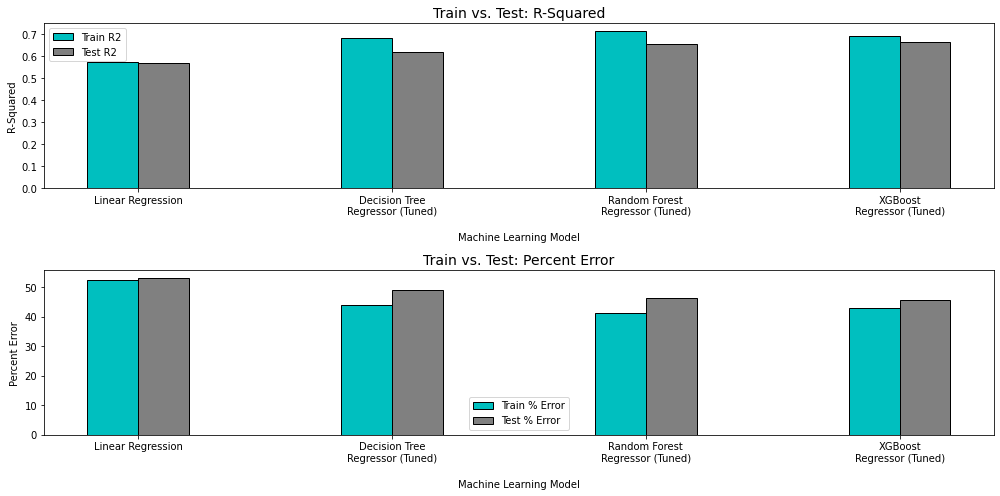

In [104]:
fig, ax = plt.subplots(2, 1, figsize =(14, 7))


# Define the variables to store the data 
train_r = [r2_train_reg, r2_train_dt, r2_train_rf, r2_train_xgb] 
test_r = [r2_test_reg, r2_test_dt, r2_test_rf, r2_test_xgb] 

train_percent_error = [error_train_reg, error_train_dt, error_train_rf, error_train_xgb]
test_percent_error = [error_test_reg, error_test_dt, error_test_rf, error_test_xgb]

# Set position of each bar
train_bar = np.arange(len(train_r)) 
test_bar = [x + 0.2 for x in train_bar] 

# Create Bar Chart for r-squared
ax[0].bar(train_bar, train_r, color ='c', width = 0.2, edgecolor ='black', label ='Train R2') 
ax[0].bar(test_bar, test_r, color ='grey', width = 0.2, edgecolor ='black', label ='Test R2')
ax[0].set_title('Train vs. Test: R-Squared', fontsize=14)
ax[0].set_xlabel('\nMachine Learning Model') 
ax[0].set_ylabel('R-Squared') 
ax[0].set_xticks([r + 0.1 for r in range(len(train_r))], 
           ['Linear Regression', 'Decision Tree\nRegressor (Tuned)',
            'Random Forest\nRegressor (Tuned)', 'XGBoost\nRegressor (Tuned)'])
ax[0].legend()

# Create Bar Chart for Percent Error
ax[1].bar(train_bar, train_percent_error, color ='c', width = 0.2, edgecolor ='black', label ='Train % Error') 
ax[1].bar(test_bar, test_percent_error, color ='grey', width = 0.2, edgecolor ='black', label ='Test % Error')
ax[1].set_title('Train vs. Test: Percent Error', fontsize=14)
ax[1].set_xlabel('\nMachine Learning Model') 
ax[1].set_ylabel('Percent Error') 
ax[1].set_xticks([r + 0.1 for r in range(len(test_percent_error))], 
           ['Linear Regression', 'Decision Tree\nRegressor (Tuned)',
            'Random Forest\nRegressor (Tuned)', 'XGBoost\nRegressor (Tuned)'])
ax[1].legend()

plt.tight_layout()
plt.show() 

In [105]:
X_test['Price'] = np.exp(y_test)

In [106]:
X_test['Linear Regression Price'] = np.exp(y_pred_test_reg).round(2)
X_test['Decision Tree Price'] = np.exp(y_pred_test_dt).round(2)
X_test['Random Forest Price'] = np.exp(y_pred_test_rf).round(2)
X_test['XGBoost Price'] = np.exp(y_pred_test_xgb.astype(np.float64)).round(2)

In [107]:
price_comparison = X_test.iloc[:,-5:]
price_comparison.head(10)

,Price,Linear Regression Price,Decision Tree Price,Random Forest Price,XGBoost Price
23002,63.0,134.79,129.59,117.47,122.25
3222,230.0,144.27,166.40,166.88,152.31
8501,120.0,118.64,135.77,125.83,126.79
17181,61.0,64.11,61.54,65.77,62.66
29528,260.0,188.49,201.16,188.03,177.08
24758,35.0,51.31,54.81,50.38,45.65
21391,150.0,160.52,161.41,167.26,160.41
33412,153.0,149.10,159.08,145.37,149.66
60574,97.0,79.94,80.00,77.59,75.89
10950,155.0,121.73,110.66,113.21,118.44
